In [1]:
import sys
import time
import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py

from numba import jit,njit

In [2]:
f = h5py.File('small_QL_g_s1_p0.h5', 'r')

def printname(name):
    print(name)
f.visit(printname)

time_stamp = 0

scales
scales/Tr
scales/constant
scales/iteration
scales/kth
scales/kz
scales/r
scales/r/1.0
scales/sim_time
scales/th
scales/th/1.0
scales/timestep
scales/wall_time
scales/world_time
scales/write_number
scales/z
scales/z/1.0
tasks
tasks/ph
tasks/pl
tasks/uh
tasks/ul
tasks/vh
tasks/vl
tasks/wh
tasks/wl


In [3]:
r = f['scales']['r']['1.0']
z = f['scales']['z']['1.0']
th = f['scales']['th']['1.0']
t = f['scales']['sim_time']

th = np.asarray(th)
z = np.asarray(z)
r = np.asarray(r)
t = np.asarray(t)

N_r = r.shape[0]
N_th = th.shape[0]
N_z = z.shape[0]
N_t = t.shape[0]

print("N_r: ", N_r)
print("N_th: ", N_th)
print("N_z: ", N_z)
print("N_t: ", N_t)

N_r:  6
N_th:  6
N_z:  6
N_t:  10


In [4]:
ul = f['tasks']['ul'][time_stamp]
uh = f['tasks']['uh'][time_stamp]

vl = f['tasks']['vl'][time_stamp]
vh = f['tasks']['vh'][time_stamp]

wl = f['tasks']['wl'][time_stamp]
wh = f['tasks']['wh'][time_stamp]

ul = np.asarray(ul)
uh = np.asarray(uh)

vl = np.asarray(vl)
vh = np.asarray(vh)

wl = np.asarray(wl)
wh = np.asarray(wh)

v_r = ul + uh
v_theta = vl + vh
v_z = wl + wh

print("v_r shape: ",v_r.shape)
print("v_theta shape: ",v_theta.shape)
print("v_z shape: ",v_z.shape)

v_r shape:  (6, 6, 6)
v_theta shape:  (6, 6, 6)
v_z shape:  (6, 6, 6)


In [5]:
print(z)

[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667]


In [6]:
print(r)

[0.05085185 0.05732233 0.06852952 0.08147048 0.09267767 0.09914815]


In [7]:
print(th)

[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776]


In [8]:
v_r_f = np.fft.fft(v_r,axis=1)
v_theta_f = np.fft.fft(v_theta,axis=1)
v_z_f = np.fft.fft(v_z,axis=1)

print(type(v_z_f))
print(type(v_z_f[0][0][0]))

<class 'numpy.ndarray'>
<class 'numpy.complex128'>


In [64]:
@njit(fastmath = True, parallel = True)
def compute_eigen(r, z, N_th, N_r, N_z, v_r_f, v_theta_f, v_z_f):
    dz = z[1]-z[0]
#     kTh = np.arange(N_th, dtype=np.int32)
#     kTh = np.reshape(kTh,(kTh.shape[0],1))
    Q = np.zeros((N_th,1),dtype=np.float64)    
#     print(Q.shape)
#     print("Q: ",type(Q))
#     print("Q[0]: ",type(Q[0][0]))

    for m in range(N_th):
        eigen_val = 0.0
        #print(type(eigen_val))
        for R in range(N_r):
            # print("R: ",R)
            if R==0:
                rdr = r[R]*(r[1]-r[0]) 
            else:
                rdr = r[R]*(r[R]-r[R-1])
            #   rdr = r[R]*(r[R]-r[R-1])
            for Z in range(1,N_z):
                Q_v_r = v_r_f[Z][m][R]
                Q_v_theta = v_theta_f[Z][m][R]
                Q_v_z = v_z_f[Z][m][R]
                
                power_amplitude = (Q_v_r)*np.conj(Q_v_r) + (Q_v_theta)*np.conj(Q_v_theta) + (Q_v_z)*np.conj(Q_v_z)
                # print(type(power_amplitude))
                power_amplitude = power_amplitude.real
                # print(power_amplitude)
                # print(power_amplitude.shape
                eigen_val += (rdr*power_amplitude)
        Q[m][0] = 2*(np.pi)*dz*eigen_val

#     par_func = np.vectorize(compute_mode)    
#     Q = par_func(kTh);
    
#     print(Q.shape)
#     print("Q: ",type(Q))
    return Q

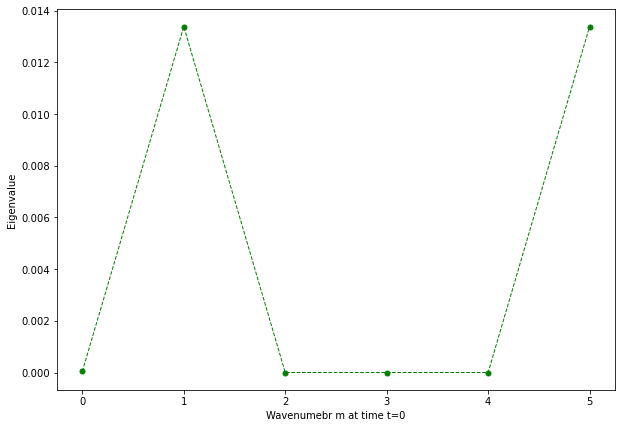

In [65]:
Q_t = compute_eigen(r, z, N_th, N_r, N_z, v_r_f, v_theta_f, v_z_f)
# print("Q_t: ",Q_t)
# print("Q Shape: ",Q_t.shape)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)

plt.plot(Q_t,color='green', marker='o', linestyle='dashed',linewidth=1, markersize=5)
plt.xlabel('Wavenumebr m at time t={}'.format(0))
plt.ylabel('Eigenvalue')
file_name = str(t[0])+".png"
plt.savefig(file_name)
plt.show()